In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import wandb
from ast import literal_eval
from tensorflow.keras.backend import categorical_crossentropy
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Rescaling, MaxPooling2D, Dropout, Flatten, Dense, Normalization
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def Model(config):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), input_shape=x_train.shape[1:], padding='same'))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Conv2D(32, 3, input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(3, activation='softmax'))
    return model

In [ ]:
config = {
    'image_size': (256,266,3),
    'dropout_1': 0.3,
    'dropout_2': 0.1,
    'dropout_3': 0.1,
}

config.update({
    'batch_size': 50,
    'epochs': 500,
    'learning_rate': 0.05,
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 30,
    'LR_plateau_patience': 10,
    'reduce_LR_factor': 0.1,
    'reduce_LR_minLR': 1e-6,
    'beta_1': 0.9,
    'beta_2': 0.999
})

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(config["random_seed"])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=config['early_stopping_patience']
)

LR_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=config['LR_plateau_patience'],
    factor=config['reduce_LR_factor'],
    min_lr=config['reduce_LR_minLR'],
    verbose=0
)

In [ ]:
ohe = OneHotEncoder()
dict = {"B":0, "C":1, "M":2}
cand = pd.read_csv("/content/drive/MyDrive/nolabels.csv")
images = np.load("/content/drive/MyDrive/imagecsv.npy")

Ylen = len(images)

Y_no = np.array([dict[item] for item in cand['Label']]).reshape(Ylen,1)
Y_one_hot = ohe.fit_transform(Y_no).toarray()

In [ ]:
x_trainp, x_test, y_trainp, y_test = train_test_split(images, Y_one_hot, random_state = 42, test_size=0.2, train_size=0.8)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, Y_one_hot, random_state = 101, test_size=0.25)

In [ ]:
#x_train,x_val, y_train, y_val = train_test_split(x_trainp, y_trainp, random_state = 42, test_size = 0.1,train_size =0.9)

In [ ]:
model = Model(config)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      18496     
                                                        

In [ ]:
def custom_accuracy(y_true, y_pred):
    #print(y_true, y_pred)
    tflat = tf.argmax(y_true)
    pflat = tf.argmax(y_pred)
    #print(tflat, pflat)
    ca = tf.keras.metrics.Accuracy()
    print(ca(labels = tflat, predictions = pflat))
    return 0

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'],
    beta_1=config['beta_1'],
    beta_2=config['beta_2']
)
model.compile(optimizer=optimizer, loss=config['loss'], metrics=['categorical_accuracy'])

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

t_generator = train_datagen.flow(x_train, y_train, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
v_generator = val_datagen.flow(x_val, y_val, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

def multiinput_train_generator():
    while True:
        # get the data from the generator
        # data is [[img], [metadata and labels]]
        # yields batch_size number of entries
        data = t_generator.next()

        imgs = data[0]
        targets = data[1]

        yield imgs, targets

def multiinput_val_generator():
    while True:
        data = v_generator.next()

        imgs = data[0]
        targets = data[1]

        yield imgs, targets


training_generator = multiinput_train_generator()
validation_generator = multiinput_val_generator()

In [ ]:
class Metrics(keras.callbacks.Callback):

    def __init__(self, val_data, batch_size = 20):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        print(self.validation_data)
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        batches = len(list(self.validation_data))
        total = batches * self.batch_size

        val_pred = np.zeros((total,1))
        val_true = np.zeros((total))

        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch+1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch+1) * self.batch_size] = yVal

        val_pred = np.squeeze(val_pred)
        #_val_f1 = f1_score(val_true, val_pred)
        #_val_precision = precision_score(val_true, val_pred)
        #_val_recall = recall_score(val_true, val_pred)

        print(val_pred)

        #self.val_f1s.append(_val_f1)
        #self.val_recalls.append(_val_recall)
        #self.val_precisions.append(_val_precision)

        return

    def get_data(self):
        return self._data
metrics = Metrics(validation_generator)

In [ ]:
history = model.fit(x=x_train, y=y_train, epochs=config["epochs"], callbacks = [early_stopping, LR_plateau], validation_data=(x_val, y_val)) #, steps_per_epoch=0.8*len(x_train) // config["batch_size"], validation_steps=3)

Epoch 1/500
6/6 [==============================] - 6s 186ms/step - loss: 1.5352 - categorical_accuracy: 0.3161 - val_loss: 1159901.2500 - val_categorical_accuracy: 0.2586 - lr: 0.0500
Epoch 2/500
6/6 [==============================] - 1s 123ms/step - loss: 1.0425 - categorical_accuracy: 0.4598 - val_loss: 632816.8125 - val_categorical_accuracy: 0.2586 - lr: 0.0500
Epoch 3/500
6/6 [==============================] - 1s 122ms/step - loss: 0.8306 - categorical_accuracy: 0.6207 - val_loss: 262023.4844 - val_categorical_accuracy: 0.2586 - lr: 0.0500
Epoch 4/500
6/6 [==============================] - 1s 123ms/step - loss: 0.8126 - categorical_accuracy: 0.6207 - val_loss: 75011.4062 - val_categorical_accuracy: 0.2586 - lr: 0.0500
Epoch 5/500
6/6 [==============================] - 1s 121ms/step - loss: 0.7362 - categorical_accuracy: 0.5862 - val_loss: 25268.2734 - val_categorical_accuracy: 0.2586 - lr: 0.0500
Epoch 6/500
6/6 [==============================] - 1s 126ms/step - loss: 0.7026 - cate

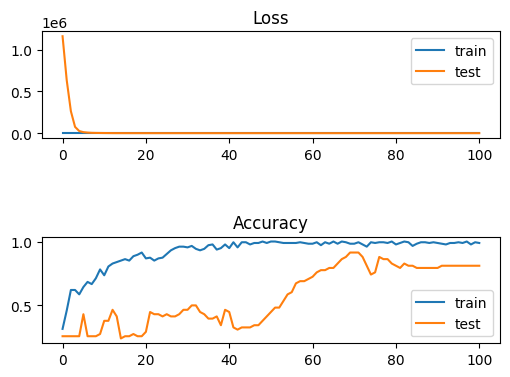

In [ ]:
#_, train_acc = model.evaluate(x_train, y_train, verbose=0)
#_, test_acc = model.evaluate(x_val, y_val, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
fig, ax = plt.subplots(2, 1)
fig.tight_layout(pad=5.0)
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_train, y_train, verbose=0)

[0.00014261862088460475, 1.0]

In [ ]:
xtest2 = images[0:44]

In [ ]:
ytest2 = Y_one_hot[0:44]

In [ ]:
ypred = model.predict(xtest2)

2/2 [==============================] - 1s 501ms/step


In [ ]:
ypred

array([[7.42368286e-07, 9.99999166e-01, 1.08192559e-07],
       [1.33833417e-03, 9.98651087e-01, 1.05812496e-05],
       [5.78834988e-05, 6.60481965e-05, 9.99876022e-01],
       [1.22327295e-08, 9.99999881e-01, 1.61526657e-07],
       [5.49694657e-01, 4.50211823e-01, 9.34958516e-05],
       [9.99889970e-01, 4.60436240e-05, 6.40569997e-05],
       [6.52782205e-07, 9.99999285e-01, 1.04001757e-07],
       [3.64076695e-04, 9.99188840e-01, 4.47057304e-04],
       [9.94044721e-01, 5.94748044e-03, 7.86867440e-06],
       [9.99360144e-01, 6.30761788e-04, 9.07495451e-06],
       [8.95970911e-02, 9.03850138e-01, 6.55271532e-03],
       [1.77405852e-07, 1.15118073e-05, 9.99988317e-01],
       [9.41903949e-01, 5.29411882e-02, 5.15483227e-03],
       [2.87819747e-02, 9.67146635e-01, 4.07143729e-03],
       [2.88010853e-07, 9.99999762e-01, 5.56434943e-09],
       [9.91819859e-01, 7.39414972e-05, 8.10622610e-03],
       [3.20800173e-04, 2.72418489e-04, 9.99406815e-01],
       [1.57148907e-06, 9.99996

In [ ]:
norm_arr = ypred / np.linalg.norm(ypred, axis=1, keepdims=True)

In [ ]:
norm_arr

array([[2.4808681e-02, 8.2409440e-04, 9.9969184e-01],
       [3.5530746e-02, 9.9936861e-01, 1.8913306e-05],
       [1.0000000e+00, 3.1828365e-06, 8.4301871e-11],
       [4.2309975e-03, 9.9995065e-01, 8.9855595e-03],
       [4.5630499e-09, 2.8376837e-05, 1.0000000e+00],
       [6.0261334e-09, 1.9651206e-05, 1.0000000e+00],
       [9.9979609e-01, 2.0193350e-02, 1.7506815e-06],
       [9.9997962e-01, 6.3878447e-03, 2.4033918e-08],
       [9.9999964e-01, 8.2922645e-04, 4.0081362e-11],
       [9.9810833e-01, 6.1479062e-02, 2.4180571e-10],
       [9.9999225e-01, 3.9392319e-03, 2.6926770e-07],
       [5.0428825e-06, 1.2990928e-04, 1.0000000e+00],
       [8.2976121e-01, 5.5811852e-01, 7.8168370e-05],
       [2.9240016e-06, 1.0000000e+00, 6.1390608e-07],
       [1.3648604e-06, 1.0000000e+00, 7.3368579e-07],
       [1.0000000e+00, 5.7602956e-06, 3.9267078e-08],
       [2.0501646e-04, 9.9999994e-01, 5.4127877e-08],
       [7.1070042e-07, 1.0000000e+00, 1.2773089e-06],
       [3.4467221e-06, 9.999

In [ ]:
ytest2

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
pflat = tf.argmax(ypred, axis = 1)
pflat

<tf.Tensor: shape=(44,), dtype=int64, numpy=
array([1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 2, 0, 0,
       0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1])>

In [ ]:
yflat = tf.argmax(ytest2, axis = 1)
yflat

<tf.Tensor: shape=(44,), dtype=int64, numpy=
array([1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 2, 0, 0,
       0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 1])>

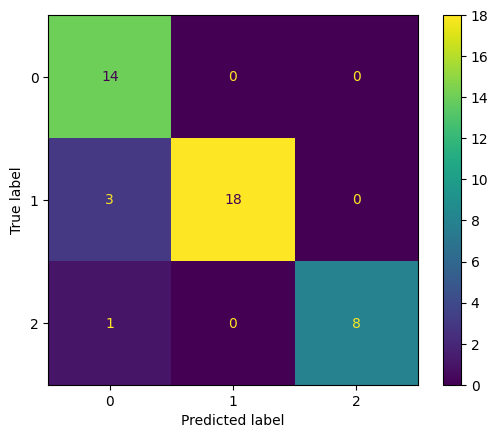

In [ ]:
cm = confusion_matrix(yflat, pflat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
import seaborn as sns

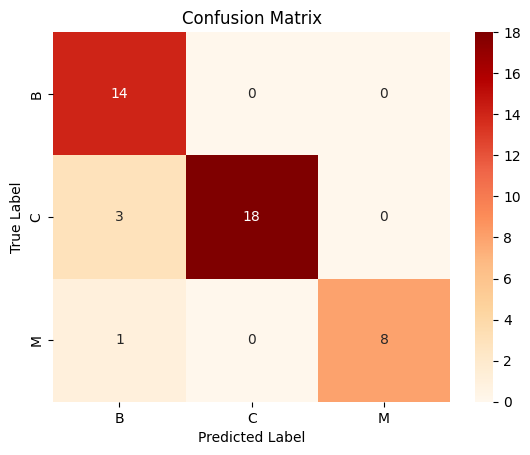

In [ ]:
g = sns.heatmap(cm, annot=True,cmap="OrRd")
g.set_xticklabels(["B", "C", "M"])
g.set_yticklabels(["B", "C", "M"])
g.set(xlabel ="Predicted Label", ylabel = "True Label", title ='Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(yflat, pflat)

0.8085106382978723

In [ ]:
arr = np.array([[2.4808681e-02, 8.2409440e-04, 9.9969184e-01],
       [3.5530746e-02, 9.9936861e-01, 1.8913306e-05],
       [1.0000000e+00, 3.1828365e-06, 8.4301871e-11],
       [4.2309975e-03, 9.9995065e-01, 8.9855595e-03]])

In [ ]:
arr[0]

array([2.4808681e-02, 8.2409440e-04, 9.9969184e-01])

In [ ]:
layer = CustomMax()

In [ ]:
layer(arr)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 1, 0, 1])>

In [ ]:
arr2 = [1, 0 , 2, 1, 0]

In [ ]:
l2 = CustomOH()
l2(layer(arr))

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [ ]:
tf.one_hot(x, 2)

ValueError: Attempt to convert a value (<__main__.CustomMax object at 0x7c659add93c0>) with an unsupported type (<class '__main__.CustomMax'>) to a Tensor.

In [ ]:
tf.math.argmax(arr, axis = 1)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 1, 0, 1])>

In [ ]:
arr.shape

(4, 3)

In [ ]:
input_shape = (2, 3, 4)
x1 = np.random.rand(*input_shape)
x2 = np.random.rand(*input_shape)
y = keras.layers.Maximum()([x1, x2])
print(y)

tf.Tensor(
[[[0.45606998 0.9507143  0.7319939  0.5986585 ]
  [0.59241456 0.15599452 0.60754484 0.8661761 ]
  [0.601115   0.94888556 0.965632   0.96990985]]

 [[0.83244264 0.21233912 0.684233   0.4401525 ]
  [0.30424225 0.52475643 0.43194503 0.9093204 ]
  [0.6118529  0.66252226 0.31171107 0.52006805]]], shape=(2, 3, 4), dtype=float32)


In [ ]:
np.argmax(arr, axis = 1)

array([2, 1, 0, 1])

In [ ]:
arr1 = [0, 1 , 2 , 0, 1]
arr2 =  [0, 1, 1, 1, 1]

tf.keras.metrics.Accuracy(arr1, arr2)

TypeError: Expected `name` argument to be a string, but got: [0, 1, 2, 0, 1]